# Feature Selection, Logistic Regression, and Congressional Elections

In the spirit of our recent election season (hah), I've decided to do some exploration in using boosted trees to identify features that have the most predictive power. Using those selected features, I'll then use a logistic model to predict whether a congressional district will be democrat or republican. 

For comparison's sake, I'll begin by specifying a logistic model with features that I pick without any empirical evidence to back up my decision.

The data describe all 435 districts in the 105th congress from 1997-1998. It contains demographic and employment data for each district as well as a variable indicating whether the district’srepresentative in the House was a Republican or not. Republican districts were coded as 1 while Democratic/independent districts were coded as 0. There are a total of 31 variables, as described below:

![Variable descriptions](congress_description.png)

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from __future__ import division
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report # important for evaluating classification
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18.5, 10.5



In [26]:
congress = pd.read_stata("http://rlhick.people.wm.edu/econ407/data/congressional_105.dta" )
congress.head()

,state,fipstate,sc,cd,repub,age65,black,blucllr,city,coast,...,miltpop,nucplant,popsqmi,populatn,rurlfarm,transprt,unemplyd,union,urban,whlretl
0,AK,2,81,1,1.0,25898,22566,31560,0,1,...,24991,0,0.964357,629099,1292,20903,26234,30.400000,222119,50986
1,AL,1,41,1,1.0,72534,164556,43449,0,1,...,1524,0,85.095802,577630,5475,10925,19799,18.200001,301197,52983
2,AL,1,41,2,1.0,75396,139311,49886,0,0,...,11250,1,56.973942,577203,12491,11820,14127,18.200001,202022,52623
3,AL,1,41,3,1.0,74506,150175,65849,0,0,...,5804,0,66.190620,577116,8863,7891,17303,18.200001,157275,45284
4,AL,1,41,4,1.0,84691,38087,74068,0,0,...,463,0,63.142357,577058,16664,9711,16724,18.200001,71451,48266


For the naive logit model, I will estimate

$$ repub = \beta_0 + \beta_1 per\_age65 + \beta_2 per\_black + \beta_3 per\_bluecllr + \beta_4 city + \beta_5 mdnincm + \beta_6 per\_unemployed + \beta_7 union $$


where per\_ indicates that variable is a percentage of the district. I use percentages so that (presumably) the results are agnostic of the size of a district and can be generalized to any region in the US. 

( I should make a geographic region indicator variable. )


In [27]:
#making percentages
variables = ['unemplyd', 'age65', 'black', 'blucllr']

for v in variables:
    congress['per_' + v] = congress[[v, 'populatn']].apply(lambda row: (row[0] / row[1])*100, axis = 1)

Before I do anything, I check for null values and get a sense of the data

In [28]:
congress[congress.repub.isnull()]

,state,fipstate,sc,cd,repub,age65,black,blucllr,city,coast,...,rurlfarm,transprt,unemplyd,union,urban,whlretl,per_unemplyd,per_age65,per_black,per_blucllr
318,OK,40,53,1,NaN,119200,99968,57876,1,0,...,1750,32948,27258,12.9,924952,117114,2.600284,11.371116,9.536474,5.521097


After doing some research on Oklahoma's first congressional district, they had republican congressman Steve Largent from 1994 to 2002. I will code that row as republican.

In [29]:
congress.repub.fillna(value = 1, inplace = True)

Lets see how balanced my data set is 

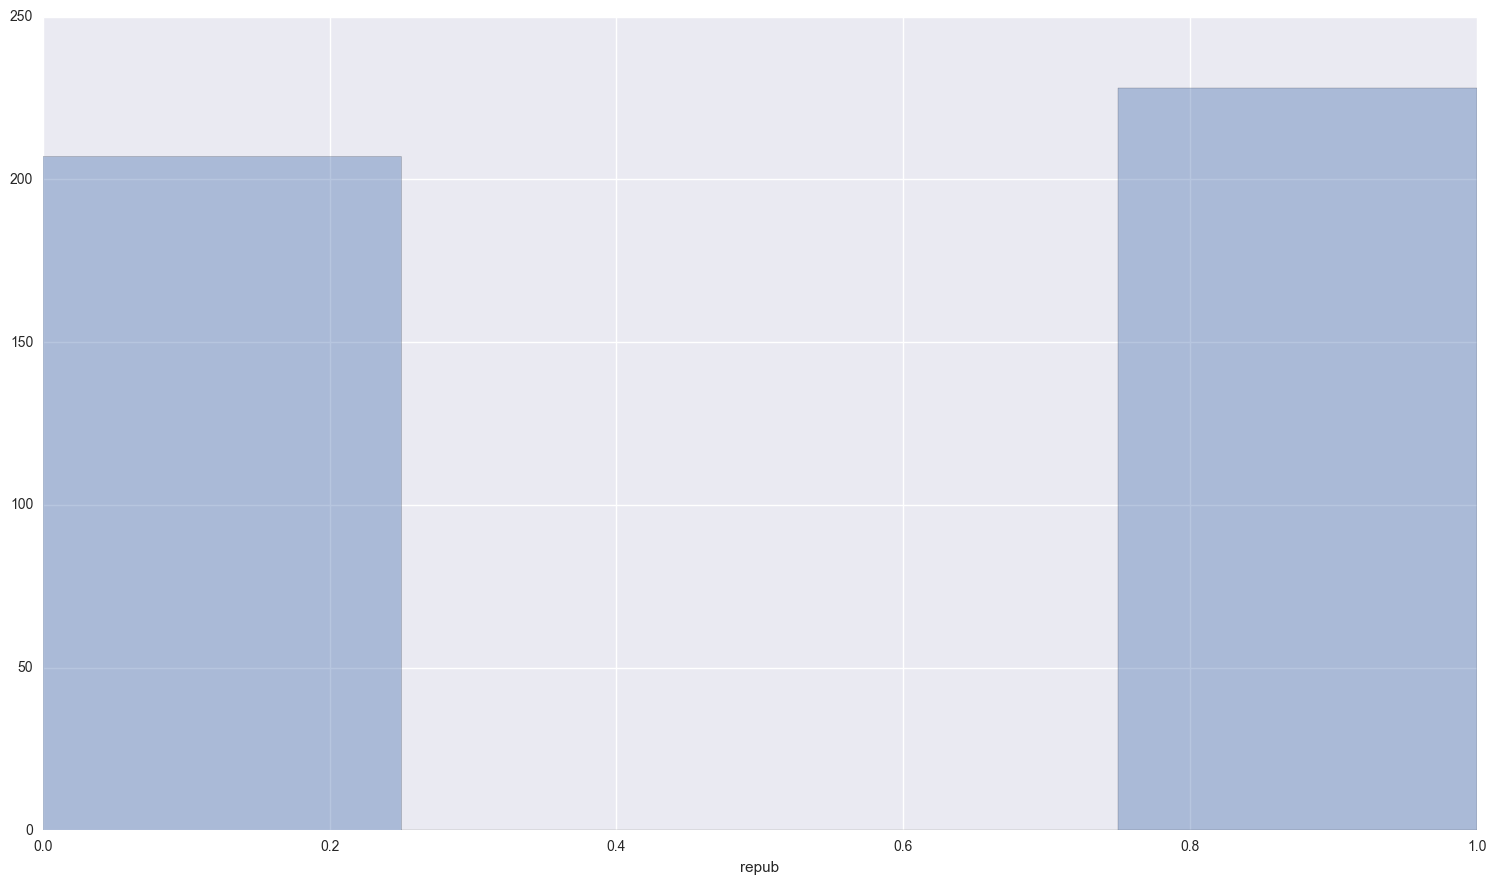

In [30]:
sns.distplot(congress.repub, kde = False); 

In [31]:
print congress.repub.value_counts()

1.0    228
0.0    207
Name: repub, dtype: int64


So our data is fairly balanced, although republicans have the slight majority. Lets check out the relationship between the blue collar workers and black population:

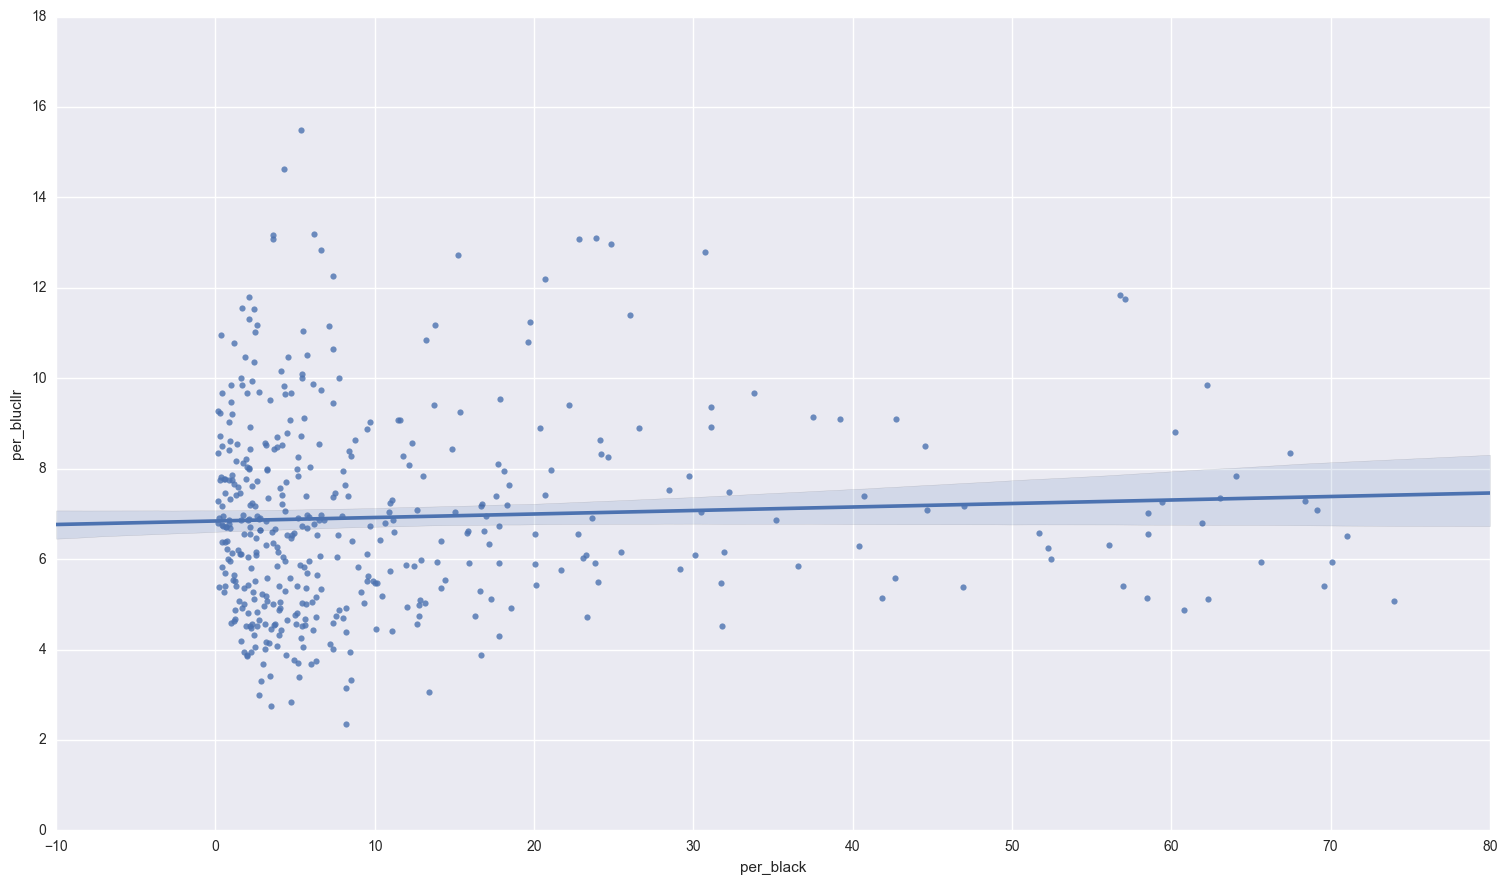

In [32]:
sns.regplot(congress.per_black, congress.per_blucllr);

There doesn't seem to be a definite relationship between the percentage of blue collar workers and percentage of black population. Lets take a look at percentage of black population and electing a republican congressman:

In [33]:
print "Districts that went Republican: \n",congress[congress.repub == 1].per_black.describe()

print "\nDistricts that went Democrat: \n",congress[congress.repub == 0].per_black.describe()

Districts that went Republican: 
count    228.000000
mean       7.139820
std        7.773183
min        0.178235
25%        2.148288
50%        4.678620
75%        8.204570
max       40.724916
Name: per_black, dtype: float64

Districts that went Democrat: 
count    207.000000
mean      17.020763
std       20.083805
min        0.131355
25%        2.776919
50%        8.122120
75%       21.369574
max       73.948710
Name: per_black, dtype: float64


In [34]:
print "Districts that went Republican: \n",congress[congress.repub == 1].per_black.describe()

print "\nDistricts that went Democrat: \n",congress[congress.repub == 0].per_black.describe()

Districts that went Republican: 
count    228.000000
mean       7.139820
std        7.773183
min        0.178235
25%        2.148288
50%        4.678620
75%        8.204570
max       40.724916
Name: per_black, dtype: float64

Districts that went Democrat: 
count    207.000000
mean      17.020763
std       20.083805
min        0.131355
25%        2.776919
50%        8.122120
75%       21.369574
max       73.948710
Name: per_black, dtype: float64


The median value for districts that went Democrat is 4 % higher than those that went republican. In addition to the districts that went Republican are more closely centered around the mean and median, where as in the districts that went Democrat, there is a significant discrepancy between the mean and median. In fact, 25 % of the data falls between 8.12 % and 21.36 % for Democratic districts, but in Republican districts that number is 4.6 % and 8.2 %.

I expect that the percentage of the population that is black will have significant predicitive power in our model. 


Examine the correlation between our variables of interest:

In [35]:
ind_vars = [ 'per_age65', 'per_black', 'per_blucllr', 'city','mdnincm', 'per_unemplyd', 'union']
congress[ind_vars].corr()

,per_age65,per_black,per_blucllr,city,mdnincm,per_unemplyd,union
per_age65,1.000000,-0.135644,-0.003851,-0.151725,-0.176406,-0.154773,-0.016208
per_black,-0.135644,1.000000,0.055332,0.232024,-0.312837,0.549604,-0.135479
per_blucllr,-0.003851,0.055332,1.000000,-0.198259,-0.470878,0.110561,-0.067490
city,-0.151725,0.232024,-0.198259,1.000000,-0.002129,0.299911,0.089047
mdnincm,-0.176406,-0.312837,-0.470878,-0.002129,1.000000,-0.505595,0.251465
per_unemplyd,-0.154773,0.549604,0.110561,0.299911,-0.505595,1.000000,0.167665
union,-0.016208,-0.135479,-0.067490,0.089047,0.251465,0.167665,1.000000


Nothing seriously outrageous to see here. Percent black and unemployment have the highest correlation at 54.9%, followed by city and unemployment at 29.9%. Something to keep in mind when we are doing feature selections.

## quick aside about MLE and Logit

I'm not going to go in to a ton detail about logistic regression, because it has been done ad nauseam. If you would like more info about it, the [wiki](https://en.wikipedia.org/wiki/Logistic_regression) is a great place to start. 

I'd like to detail a bit about MLE or maximum likelihood estimation in the context of the logit model. Stats models uses maximum likelihood to estimate the coefficients. In order to use MLE, we assume that the errors in our model are independent and identically Logit distributed. The cumulative logit function is given by:

$$ P(y = 1 | \textbf{x_i}) = \int_{-\infty}^{\textbf{x_i} \beta} f(t)dt = \frac{e^{\textbf{x_i} \beta}}{1 + e^{\textbf{x_i} \beta}}$$

The log-likelihood is is then:
$$ \Sigma_{i = 1}^{N} P(y = 1 | \textbf{x_i} \beta) \times (y_i) + (1 - P(y = 1 | \textbf{x_i} \beta) \times (1 - y_i) $$

When I run a logitstic model in statsmodels, it estimates parameters $\textbf{b}$ such that the above sum is maximized. 

So now that we know what's going on behind the scenes, lets heckin do it :)


In [36]:

dep_var = 'repub'

x_const = sm.add_constant(congress[ind_vars])
y = congress[dep_var]

#Logit and probit models

logit_results = Logit(y, x_const).fit()
logit_results.summary()

Optimization terminated successfully.
         Current function value: 0.542084
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  repub   No. Observations:                  435
Model:                          Logit   Df Residuals:                      427
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Nov 2016   Pseudo R-squ.:                  0.2166
Time:                        22:02:56   Log-Likelihood:                -235.81
converged:                       True   LL-Null:                       -301.01
                                        LLR p-value:                 5.158e-25
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            9.5500      1.618      5.902      0.000         6.378    12.722
per_age65       -0.1199      0.037     -3.217      0.001        -0.193    -0.047
per_black       -0.0504      0.013     -3.956      0.000        -0.075    -0.025
per_blucllr     -0.0712      0.063     -1.135      0.256        -0.194     0.052
city            -0.6513      0.259     -2.519      0.012        -1.158    -0.145
mdnincm      -5.843e-05   1.92e-05     -3.037      0.002     -9.61e-05 -2.07e-05
per_unemplyd    -1.4488      0.233     -6.210      0.000        -1.906    -0.992
union           -0.0280      0.016     -1.705      0.088        -0.060     0.004
================================================================================
"""

In [37]:
logit_results.get_margeff(dummy = True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  repub
Method:                          dydx
At:                           overall
================================================================================
                  dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
per_age65       -0.0221      0.007     -3.363      0.001        -0.035    -0.009
per_black       -0.0093      0.002     -4.215      0.000        -0.014    -0.005
per_blucllr     -0.0122      0.010     -1.269      0.205        -0.031     0.007
city            -0.1201      0.046     -2.586      0.010        -0.211    -0.029
mdnincm      -1.077e-05    3.4e-06     -3.163      0.002     -1.74e-05  -4.1e-06
per_unemplyd    -0.2670      0.035     -7.538      0.000        -0.336    -0.198
union           -0.0052      0.003     -1.725      0.085        -0.011     0.001
================================================================================
"""

Before I look at how well the model is classifying, I'll interpret the marginal effects:

For each variable that is a percentage, the marginal effect is the amount that the probability drops for each percent increase in that variable. Those include per_age65, per_black, per_bluecllr, per_unemplyd, and union. The most notable of these is that for every percentage increase in unemployment, the probability that the district elects a republican congressman or woman  decreases by almost 27%!! Oh how the times have changed.

Another interesting result is that for every 10,000 \$ increase in median income, the probability of a republican goes down by about 10.7 %. This goes against conventional wisdom that says that richer folks prefer republican canidates. Again, I think that if region was controlled for, the effect may be different.

Something that I think would be interesting to explore is how religious preferences within each district affect republican chances. Anyway, on to the classification reports

In [38]:
predictions = np.array([1 if x >= 0.5 else 0 for x in logit_results.predict()])

print classification_report(congress.repub, predictions)
print "Confusion matrix:\n"
print confusion_matrix(congress.repub, predictions)

             precision    recall  f1-score   support

        0.0       0.74      0.67      0.70       207
        1.0       0.72      0.78      0.75       228

avg / total       0.73      0.73      0.73       435

Confusion matrix:

[[139  68]
 [ 50 178]]


Okay, so the model isn't *awful*, although it could use some serious improvement. Democratic districts are only classified correctly (139 / (139 + 68)) = 67% of the time. Okay so that's not very good at all.

We proceed boldy forward by diving in to **Feature Selection**

## Using a Boosted classifier to do Feature Selection

A cool feature of the xgboost library is that after it estimates all the trees, it calculates for each tree the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function. For more information, check out [this](http://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting) stack overflow question.

I start with using all variables except those that are identifying information like state, FIPS code etc. I also make the rest of the population count variables in to percentages so that they are comparable to other districts.

In [40]:
congress.columns.values

array(['state', 'fipstate', 'sc', 'cd', 'repub', 'age65', 'black',
       'blucllr', 'city', 'coast', 'construc', 'cvllbrfr', 'enroll',
       'farmer', 'finance', 'forborn', 'gvtwrkr', 'intrland', 'landsqmi',
       'mdnincm', 'miltinst', 'miltmajr', 'miltpop', 'nucplant', 'popsqmi',
       'populatn', 'rurlfarm', 'transprt', 'unemplyd', 'union', 'urban',
       'whlretl', 'per_unemplyd', 'per_age65', 'per_black', 'per_blucllr'], dtype=object)

In [47]:
needs_convert = ['construc', 'cvllbrfr', 'enroll', 'farmer', 'finance', 'forborn', 'gvtwrkr', 'miltpop',
                 'rurlfarm', 'transprt', 'urban', 'whlretl']
for v in needs_convert:
    congress['per_' + v] = congress[[v, 'populatn']].apply(lambda row: (row[0] / row[1])*100, axis = 1)

all_ind_vars = ['per_age65', 'per_black', 'per_blucllr', 'city','coast', 'per_construc', 'per_cvllbrfr', 
                'per_enroll','per_farmer', 'per_finance', 'per_forborn', 'per_gvtwrkr', 'intrland', 'landsqmi', 
                'mdnincm', 'miltinst', 'miltmajr', 'per_miltpop', 'nucplant', 'popsqmi','populatn', 'per_rurlfarm', 
                'per_transprt', 'per_unemplyd', 'union', 'per_urban','per_whlretl']



In [48]:
boosted = XGBClassifier(max_depth= 4, objective= 'binary:logistic')
boosted.fit(congress[all_ind_vars], congress.repub)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

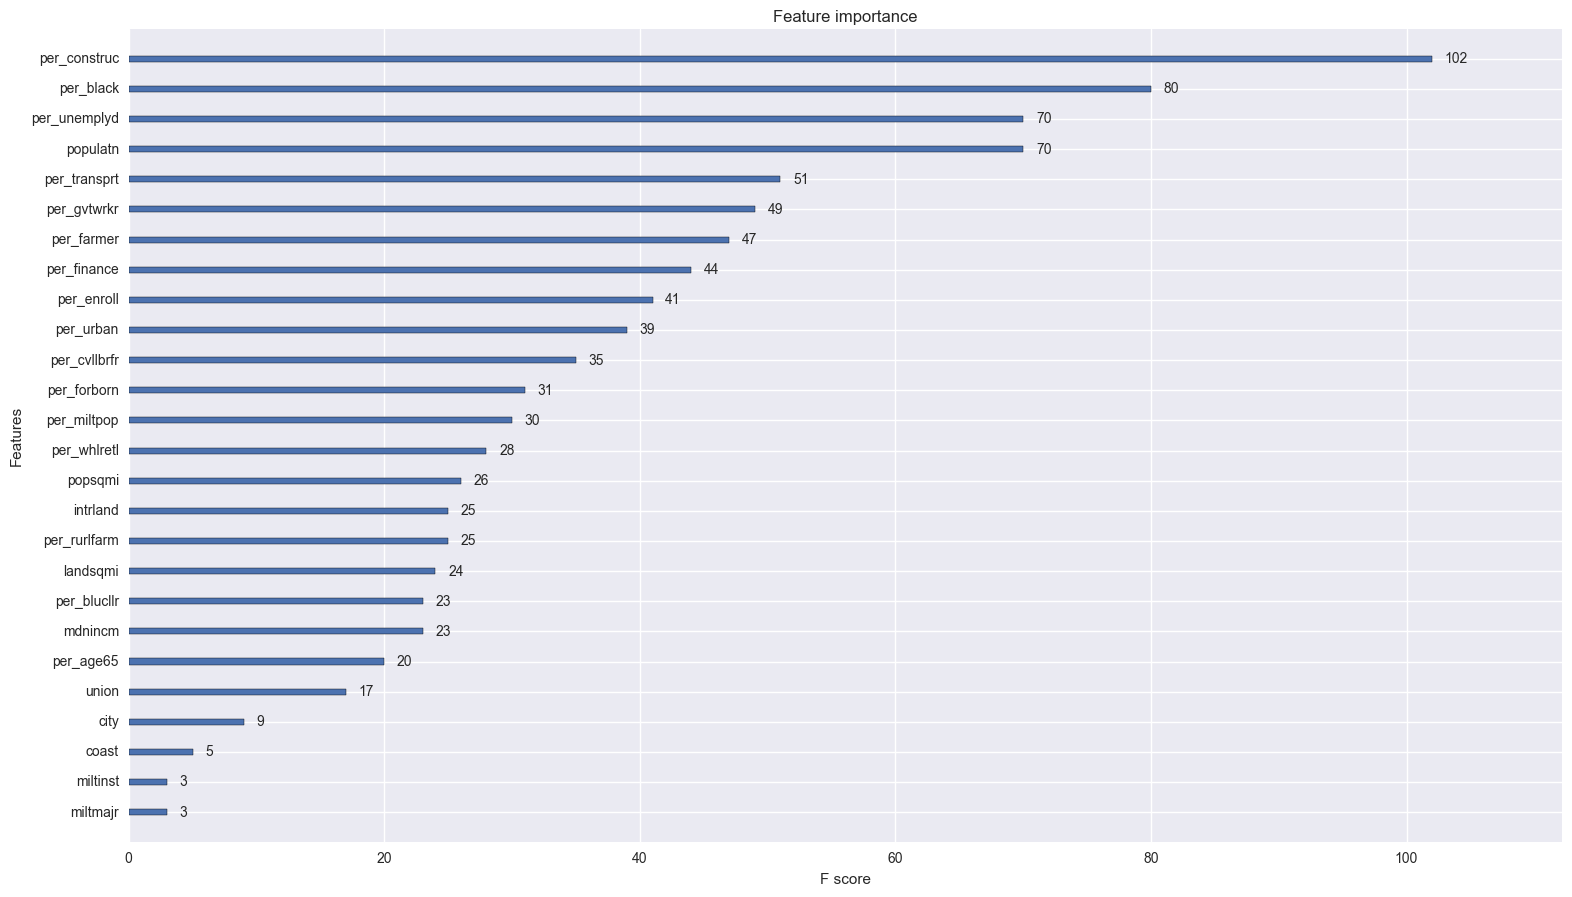

In [49]:
xgb.plot_importance(boosted.booster());

Some surprising results, some expected results.

**Unexpected:**

The percentage of the population that works construction is the most important feature... interesting. Personally, I would consider construction work to be blue collar work, however, they weren't counted as part of the population that constituted blue collar workers. Maybe instead of campaigning with the steel workers, congressmen should pander to construction unions (do those even exist?). The size of the district also plays a significant role. It will be interesting to see whether size contributes positively or negatively to the probability of a republican.

Government, transport and utility workers also contribute significantly. A common theme here is features that are most important are either directly related to government work or somehow often implicated with government. Indeed, whether a person is employed or not seriously colors their view of how the government should be run. 


**Expected**

I was right about unemployment and the black population playing a large role in elections! Sweet validation. 



In [54]:
new_vars = ['per_construc', 'per_black', 'per_unemplyd', 'populatn', 'per_transprt', 'per_gvtwrkr', 'city', 'coast',
           'mdnincm', 'per_enroll' ]
new_x_const = sm.add_constant(congress[new_vars])

new_model = Logit(congress.repub, new_x_const).fit()
new_model.summary()

Optimization terminated successfully.
         Current function value: 0.508994
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  repub   No. Observations:                  435
Model:                          Logit   Df Residuals:                      424
Method:                           MLE   Df Model:                           10
Date:                Mon, 28 Nov 2016   Pseudo R-squ.:                  0.2644
Time:                        23:36:05   Log-Likelihood:                -221.41
converged:                       True   LL-Null:                       -301.01
                                        LLR p-value:                 4.741e-29
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -3.5565      2.331     -1.526      0.127        -8.126     1.013
per_construc     0.3817      0.204      1.868      0.062        -0.019     0.782
per_black       -0.0336      0.012     -2.754      0.006        -0.058    -0.010
per_unemplyd    -1.5972      0.249     -6.413      0.000        -2.085    -1.109
populatn      9.158e-06   3.21e-06      2.856      0.004      2.87e-06  1.54e-05
per_transprt    -0.1102      0.217     -0.508      0.612        -0.535     0.315
per_gvtwrkr     -0.0869      0.063     -1.385      0.166        -0.210     0.036
city            -0.4184      0.277     -1.510      0.131        -0.961     0.125
coast           -0.6557      0.264     -2.483      0.013        -1.173    -0.138
mdnincm      -4.456e-06   1.77e-05     -0.252      0.801     -3.92e-05  3.03e-05
per_enroll       0.2150      0.060      3.569      0.000         0.097     0.333
================================================================================
"""

In [55]:
new_predictions = np.array([1 if x >= 0.5 else 0 for x in new_model.predict()])

print classification_report(congress.repub, new_predictions)
print "Confusion matrix:\n"
print confusion_matrix(congress.repub, new_predictions)

             precision    recall  f1-score   support

        0.0       0.77      0.69      0.73       207
        1.0       0.74      0.82      0.78       228

avg / total       0.76      0.76      0.76       435

Confusion matrix:

[[143  64]
 [ 42 186]]


In [56]:
new_model.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  repub
Method:                          dydx
At:                           overall
================================================================================
                  dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
per_construc     0.0653      0.034      1.896      0.058        -0.002     0.133
per_black       -0.0058      0.002     -2.837      0.005        -0.010    -0.002
per_unemplyd    -0.2734      0.035     -7.884      0.000        -0.341    -0.205
populatn      1.568e-06   5.32e-07      2.947      0.003      5.25e-07  2.61e-06
per_transprt    -0.0189      0.037     -0.508      0.611        -0.092     0.054
per_gvtwrkr     -0.0149      0.011     -1.396      0.163        -0.036     0.006
city            -0.0716      0.047     -1.524      0.128        -0.164     0.020
coast           -0.1122      0.044     -2.551      0.011        -0.198    -0.026
mdnincm      -7.627e-07   3.03e-06     -0.252      0.801      -6.7e-06  5.18e-06
per_enroll       0.0368      0.010      3.761      0.000         0.018     0.056
================================================================================
"""